In [32]:
%matplotlib notebook
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import scipy
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d as gf1d
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import uniform_filter as uf
from skimage.transform import downscale_local_mean #For binning

import xarray as xr #package for labeling and adding metadata to multi-dimensional arrays

import sys
#sys.path.append("../kai_colloids/PyDDM") #must point to the PyDDM folder
#import ddm_analysis_and_fitting as ddm   

import tiff_file 

import io 
import sys
import csv

import os
import glob #glob is helpful for searching for filenames or directories
import pickle #for saving data
### usually this block prints out "nd2reader module not found. Reading of .nd2 files disabled." on the first run
### this is fine (unless you need to read .nd2 files), just re-run this block to make the error go away

## First define the functions we will need to use
### The Structural Image Autocorrelation (SIA) function is the second function defined below

In [33]:
### this function (newRadav) finds the radial average of the image autocorrelation in the SIA function 
def newRadav(im, limangles=False, angRange=None, mask=None, rev=False,
             debug_q = None):
    if mask is None:
        hasMask = False
    else:
        hasMask = True
    nx,ny = im.shape
    xx = np.arange(-(nx-1)/2., nx/2.)
    yy = np.arange(-(ny-1)/2., ny/2.)
    #x,y = np.meshgrid(xx,yy)
    x,y = np.meshgrid(yy,xx)
    q = np.sqrt(x**2 + y**2)
    angles = np.arctan2(x,y)
    
    qx = np.arange(-1*nx/2,nx/2)*(1./nx) * max(nx,ny)
    qy = np.arange(-1*ny/2,ny/2)*(1./ny) * max(nx,ny)
    qxx,qyy = np.meshgrid(qy,qx) #qy,qx is correct order
    q_new = np.sqrt(qxx**2 + qyy**2)
    
    if debug_q is not None:
        return q_new.round().astype(int)==debug_q
    
    if mask is None:
        mask = np.ones_like(angles)
    if angRange is not None:
        w1 = np.where(angles>angRange[0])
    else:
        w1 = np.where(angles>(13*np.pi/14))
    if mask is None:
        mask[w1]=0
        mask = mask * np.rot90(np.rot90(mask))
        mask = mask * np.flipud(mask)
        mask[np.where(mask==0)] = np.nan
        if rev:
            mask = np.rot90(mask)
    qr = q_new.round().astype(int)
    #rs = np.arange(0,(nx-1)/2)
    rs = np.arange(0,(max(nx,ny)-1)/2) 
    radav = np.zeros((len(rs)),dtype=float)
    for i in range(0,len(rs)):
        w = np.where(qr==rs[i])
        if len(w[0])>0:
            if limangles or hasMask:
                newim = im*mask
                radav[i] = np.nanmean(newim[w])
            else:
                radav[i] = np.nanmean(im[w])
        #else:
        #    print i
    return radav

### the SIA function 
def SIA(image, filter=True, filtersize=600, bin=True, binsize=2):
    ''' Computes image autocorrelation. 
    Takes as input:
        image: 2D image
        filter: Boolean, if true will filter image with uniform filter
        filtersize: size for uniform filtering
    Returns:
        corr_im: the image autocorrelation (this will be same size as image)
        rav_corr: radially averaged image autocorrelation '''
    
    ### Crop image
    #image = im[:1440, :1440]    ###option to crop out any large noise features 
        
    if filter:
        image = image*1.0 - uf(image,filtersize)   ###uniform filter, removes background. ("filtersize" is pixel area)
    if bin:
        image = downscale_local_mean(image, (binsize,binsize), cval=1)   ### OPTIONAL (binning makes things run faster)
    image = 1.0*image-image.mean() #subtract mean
    image = image/image.std() #normalize by standard deviation
    corr_im = abs(fftshift(ifft2(fft2(image)*np.conj(fft2(image)))))/(image.shape[0]*image.shape[1])
    
    ### radial average taken
    rav_corr = newRadav(corr_im)
    
    ### return ONLY rav_corr **b/c I don't need corr_im** (change this if you do need corr_im) 
    return rav_corr

###not sure if this function is necessary
def filtimage(image, filtersize=80):
    image = image*1.0 - uf(image,filtersize)
    return image

###define function to find characteristic correlation lengths of SIA curves 
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

one_over_e = 1.0/np.exp(1) #characteristic decay length 1/e = 0.36787944117144233... 

## Locate your data (tiff files) and choose where to save results     

In [34]:
directory = "Z"
exp = "9-5-22_s1_theBigOne"
### "data_dir" is the pathway to the folder holding the tiff files to be analyzed 
data_dir = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\all tiff files\\" 
### "plot_saveto" is the pathway to the folder where plots and results will be saved
plot_saveto= directory+":\\Gregor L\\__Kai Colloids\\SIA\\Data\\"+exp+"\\"

files = glob.glob(data_dir+"*_t*") ### this should generate an ordered list of files in "data_dir" which have "_t" in their name
print("found %i files" % len(files))
for i,f in enumerate(files): print (' %i \t %s' % (i, f.split('\\')[-1]))

found 36 files
 0 	 row1_t01.tif
 1 	 row1_t02.tif
 2 	 row1_t03.tif
 3 	 row1_t04.tif
 4 	 row1_t05.tif
 5 	 row1_t06.tif
 6 	 row1_t07.tif
 7 	 row1_t08.tif
 8 	 row1_t09.tif
 9 	 row1_t10.tif
 10 	 row1_t11.tif
 11 	 row1_t12.tif
 12 	 row2_t01.tif
 13 	 row2_t02.tif
 14 	 row2_t03.tif
 15 	 row2_t04.tif
 16 	 row2_t05.tif
 17 	 row2_t06.tif
 18 	 row2_t07.tif
 19 	 row2_t08.tif
 20 	 row2_t09.tif
 21 	 row2_t10.tif
 22 	 row2_t11.tif
 23 	 row2_t12.tif
 24 	 row3_t01.tif
 25 	 row3_t02.tif
 26 	 row3_t03.tif
 27 	 row3_t04.tif
 28 	 row3_t05.tif
 29 	 row3_t06.tif
 30 	 row3_t07.tif
 31 	 row3_t08.tif
 32 	 row3_t09.tif
 33 	 row3_t10.tif
 34 	 row3_t11.tif
 35 	 row3_t12.tif


## Specify pixel size, each condition (frame_names), and the time points of data collection (time_array)

In [39]:
frame_names = ["1-3 kA-WT", "WT (no kA)", "EA KaiC", "AE KaiC"]
### array containing the name for each frame in a tiff file to be run 
### e.g. frame 1 is an image of the "50% bKaiB" condition, frame 2 is an image of the "35% bKaiB" condition, etc.
#["EE KaiC (-kA)", "EA KaiC (-kA)", "WT KaiC (-kA)", "AE KaiC (-kA)"]
#["50% bKaiB", "35% bKaiB", "20% bKaiB", "AE (20% bKaiB)"]
#["1-3 kA-WT", "WT (no kA)", "EA KaiC", "AE KaiC"]
#["2-1 kA-KaiC", "1-3 kA-KaiC", "WT KaiC (-kA)", "AE KaiC (-kA)"]

time_array = [0.67, 3.67, 6.67, 10, 12.83, 17.67, 21.67, 24.92, 28.17, 45.67, 49.08, 69.25]
### array containing the time points corresponding to consecutive tiff files
### e.g. tiff files "bottom_row_t1", "middle_row_t1", and "top_row_t1" all correspond to t = 0.5 hrs, time_array[0]
#[0.42, 4.75, 8.75, 12.75, 19.92, 22.92, 25.42]
#[3.88, 21.17, 68]
#[0.55, 3.32, 42.73]
#[0.5, 4.5, 8, 12, 24]
#[0.5, 3.5, 6.5, 9.3, 12.1, 15, 18, 21, 24.5, 27.3, 40.5, 44.3]  
#s1 [0.5, 3.2, 17.75, 20, 22, 24.25, 26, 40.5, 44]
#s2 [0.85, 3.5, 18, 20.4, 22.25, 24.5, 26.2, 41.75, 44.2]
#s1 [0.67, 3.67, 6.67, 10, 12.83, 17.67, 21.67, 24.92, 28.17, 45.67, 49.08, 69.25]
#s2 [1, 3.83, 6.83, 10.17, 13.08, 18, 21.92, 25.25, 28.67, 45.92, 49.33, 69.42]

pixel_size = 0.364 # 4*0.091 = 0.364
### pixel size (microns per pixel) of frames/ images in the tiff files --- 40x olympus objective => 0.091 um/px
### IF 2x2 BINNING: multiply the original pixel size by 2^2 = 4, e.g. 4*(0.091 um/px) = 0.364 um/px

eg_im= tiff_file.imread(files[0])
print("tiff file dimensions: "+ str(eg_im.shape))

arr_length = int((len(files))/3)
print("total number of time points: "+ str(arr_length))

tiff file dimensions: (5, 1440, 1920)
total number of time points: 12


## Choose size, font, and quality level (dpi_num) for the plots to be made

In [40]:
fig_size = 10,10/1.618
###  size of output figures
font_size = 16
### font size
dpi_num = 800
### image quality level (recommendation: 600)

## Set up empty arrays to save results in 

In [41]:
im_array = [0.0] * int(arr_length)
br_corr_rad_array = [0.0] * int(arr_length)
mr_corr_rad_array = [0.0] * int(arr_length)
tr_corr_rad_array = [0.0] * int(arr_length)

br_plat_vals = [0.0] * int(arr_length)
mr_plat_vals = [0.0] * int(arr_length)
tr_plat_vals = [0.0] * int(arr_length)

all_xvalues = [0.0] * int(len(files))

## Now we can run some SIA! 

<IPython.core.display.Javascript object>


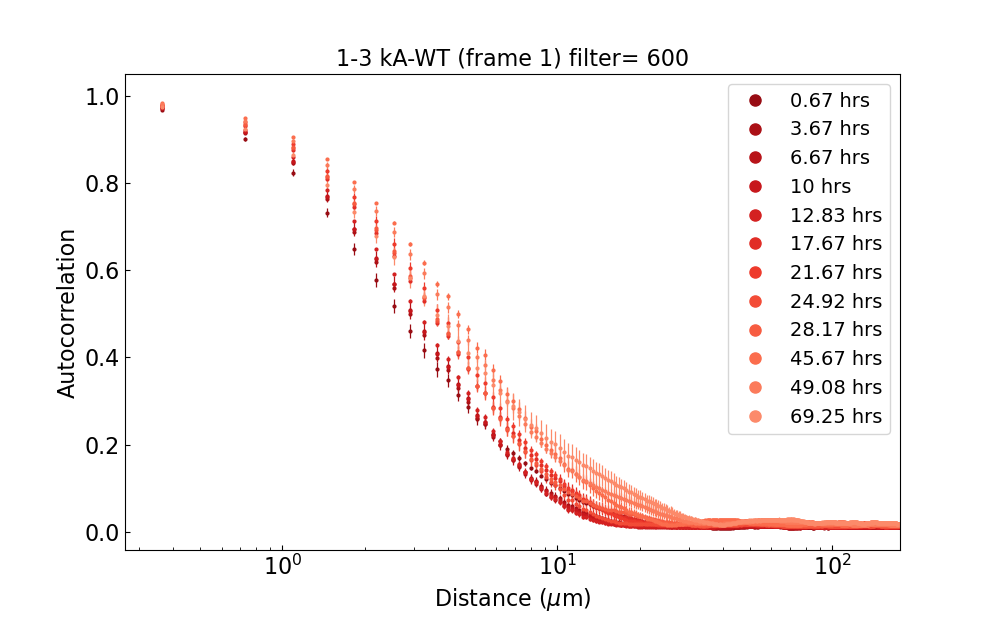

long length plateau range: from 30.940 to 100.100
image size: 174.356 x 174.356 um, last x-value= 174.356


<ipython-input-42-c6b4d46718e5>:72: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, all_xvalues[-1] +2)


In [42]:
key = 0
### "key" specifies which frame of each tiff file will be analyzed (each frame of my tiff is for a different condition)
### e.g. "key = 0" dictates that the first frame of each tiff file should be analyzed, tiff_file.imread(files[i],key=[key]

cmap = matplotlib.cm.get_cmap('Reds') 
### cmap dictates the color gradient used in plots; options: 'Reds' 'Blues' 'Greens' 'Greys' ... 

t_f = True
### If true, filters images to remove excess fluorescense background or other noise

size = 600  
### set filter size (pixel area used to estimate and remove average background pixel intensities, recommendation = 600

plat_range_from = 85
plat_range_to = 275
### set the range for finding average autocorrelation values of long distance correlation plateaus

### Set basic plot design 
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 4

cmap_num = (arr_length*2) - 2
### cmap_num is used the when plotting each curve to adjust the color gradient according to the total number of time points
### e.g. for i in range(arr_length): the color of each curve is determined by c=cmap(0.9-(i/cmap_num))

### Set up more empty arrays to save results in
mean_corr_rad_array  = [0.0] * int(len(files))
std_error_array = [0.0] * int(len(files))
all_plat_vals = np.zeros((3,1))
avg_plats  = np.empty(arr_length)
std_error_plats = np.empty(arr_length)

for i in range(arr_length):    
    frame_num = "frame %i" % int(key +1)    ### used in plot title to specify which frame of all tiff files was analyzed
    data_file = str(time_array[i]) + " hrs" ### used in legend to show time points corresponding to each curve
    
### "im_corr" is the actual SIA function which filters, bins, and fourier transforms tiff images to generate SIA curves
    br_corr_rad_array[i] = SIA(tiff_file.imread(files[i],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    mr_corr_rad_array[i] = SIA(tiff_file.imread(files[i+arr_length],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    tr_corr_rad_array[i] = SIA(tiff_file.imread(files[i+(arr_length*2)],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    
### corresponding x-values calculated according to the length of a SIA curve array (br_corr_rad_array[0]) and pixel size
    all_xvalues = np.arange(len(br_corr_rad_array[0]))*pixel_size
    
### this block calculates the average and std error of the 3 SIA curves ("br_corr_rad_array[i]", "mr_corr_rad_array[i]", and 
### "tr_corr_rad_array[i]") generated from the specified frame (key) of 3 tiff files corresponding to time point "time_array[i]"
    all_ims = np.zeros((3,len(br_corr_rad_array[i])))
    all_ims[0] = br_corr_rad_array[i]
    all_ims[1] = mr_corr_rad_array[i]
    all_ims[2] = tr_corr_rad_array[i]
    mean_corr_rad_array[i] = all_ims.mean(axis=0)
    std_error_array[i] = (all_ims.std(axis=0))/np.sqrt(3)
    
### plot the average SIA curves for each time point with the std error as error bars 
    plt.semilogx(all_xvalues, mean_corr_rad_array[i],'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=data_file)
    ax.errorbar(all_xvalues, mean_corr_rad_array[i], std_error_array[i], fmt = 'none', elinewidth=0.9, c=cmap(0.9-(i/cmap_num))) 
    

print("long length plateau range: from %5.3f to %5.3f" %(all_xvalues[plat_range_from], all_xvalues[plat_range_to]))
print("image size: %5.3f x %5.3f um, last x-value= %5.3f" %(all_xvalues[-1], all_xvalues[-1], all_xvalues[-1]))

### legend, labels and title for the plot 
### **note: the title determined in this code block carries over to all other plots unless otherwise specified 
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size) 
ax.legend(loc=0, markerscale=4.,fontsize=font_size-2)
ax.tick_params(direction='in', which='both', labelsize=font_size)

### x-axis limit is set slighlty larger than the image size, based on "all_xvalues[-1]" 
plt.xlim(0, all_xvalues[-1] +2) 

### set title
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)
plt.show()

In [13]:
###save figure 
fig.savefig(plot_saveto+"SIA avg w error for "+title+".jpg", dpi=dpi_num)
print(plot_saveto)

Z:\Gregor L\__Kai Colloids\SIA\Data\9-5-22_s1_theBigOne\


## Now we fit the SIA curves to a single exponential, fit equation: y = A(e^(-x/L1))

<IPython.core.display.Javascript object>


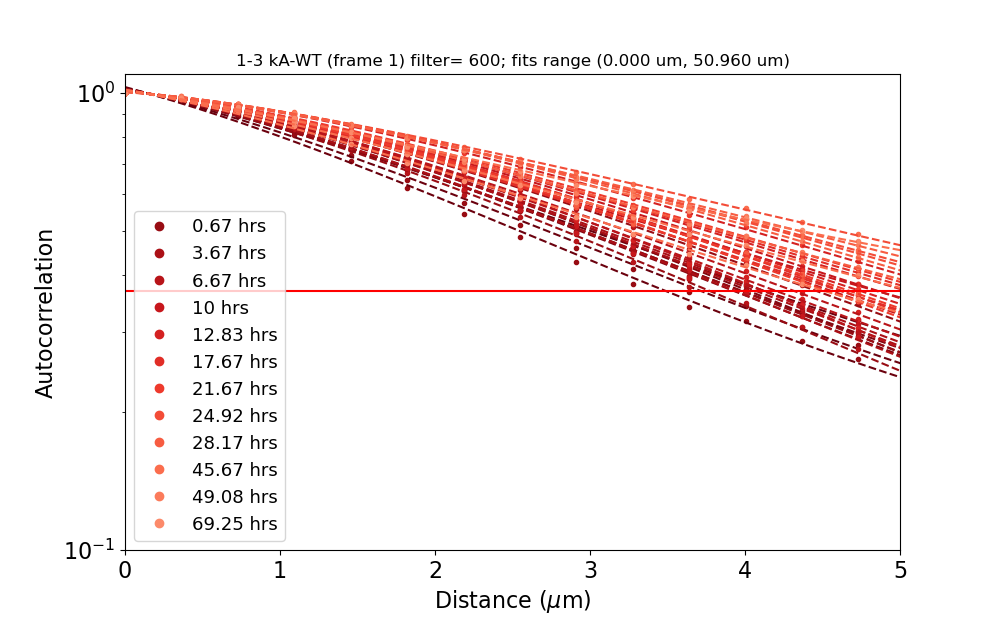

first x-value= 0.364, start fits at 0.000; fit until xlim = 50.960
br_yarray[0] = 1.000, br_yarray[1] = 0.963, br_fit_values[0] = 1.031, br_fit_values[1] = 1.020
br_yarray[0] = 1.000, br_yarray[1] = 0.971, br_fit_values[0] = 1.019, br_fit_values[1] = 1.012
br_yarray[0] = 1.000, br_yarray[1] = 0.976, br_fit_values[0] = 1.014, br_fit_values[1] = 1.008
br_yarray[0] = 1.000, br_yarray[1] = 0.973, br_fit_values[0] = 1.017, br_fit_values[1] = 1.010
br_yarray[0] = 1.000, br_yarray[1] = 0.974, br_fit_values[0] = 1.014, br_fit_values[1] = 1.008
br_yarray[0] = 1.000, br_yarray[1] = 0.979, br_fit_values[0] = 1.011, br_fit_values[1] = 1.006
br_yarray[0] = 1.000, br_yarray[1] = 0.982, br_fit_values[0] = 1.006, br_fit_values[1] = 1.003
br_yarray[0] = 1.000, br_yarray[1] = 0.979, br_fit_values[0] = 1.010, br_fit_values[1] = 1.006
br_yarray[0] = 1.000, br_yarray[1] = 0.980, br_fit_values[0] = 1.011, br_fit_values[1] = 1.006
br_yarray[0] = 1.000, br_yarray[1] = 0.983, br_fit_values[0] = 1.008, br_fit_v

Text(0.5, 1.0, '1-3 kA-WT (frame 1) filter= 600; fits range (0.000 um, 50.960 um)')

In [51]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 6

### Set up dictionary ("results_dict") and more empty arrays to save results in
results_dict = {}
results_dict["time array"] = time_array
row1_cl = [0.0] * arr_length
row2_cl = [0.0] * arr_length
row3_cl = [0.0] * arr_length

### FIT PARAMETERS: adjust these to change the range for fitting attempts 
fit_start = 0
fit_lim = -200 

x_fit_lim = (all_xvalues[fit_lim])/2
print("first x-value= %5.3f, start fits at %5.3f; fit until xlim = %5.3f" %(all_xvalues[1], all_xvalues[fit_start], x_fit_lim))
#print("Fits:")

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]

### load and plot the 3 original SIA curves corresponding to 3 tiff files associated with each time point 
    br_y_array = br_corr_rad_array[i]
    mr_y_array = mr_corr_rad_array[i]
    tr_y_array = tr_corr_rad_array[i]
    plt.semilogy(all_xvalues,br_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    plt.semilogy(all_xvalues,mr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    plt.semilogy(all_xvalues,tr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    
### x_fit_values has the same range as "all_xvalues", but includes more values to produce better fits
    x_fit_values = np.linspace(all_xvalues[fit_start], x_fit_lim, 1000) 

### the "curve_fit" function from scipy does the initial fitting attempt
    ###this section does an 18 degree polynomial fit of the SIA data (corr_rad_array) for each frame
    br_fit = np.poly1d(np.polyfit(all_xvalues[fit_start:fit_lim], br_y_array[fit_start:fit_lim], 17))
    mr_fit = np.poly1d(np.polyfit(all_xvalues[fit_start:fit_lim], mr_y_array[fit_start:fit_lim], 17))
    tr_fit = np.poly1d(np.polyfit(all_xvalues[fit_start:fit_lim], tr_y_array[fit_start:fit_lim], 17))
    
    br_fit_values = br_fit(x_fit_values)
    mr_fit_values = mr_fit(x_fit_values)
    tr_fit_values = tr_fit(x_fit_values)
    
### plot curves based on the fits 
    plt.semilogy(x_fit_values, br_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogy(x_fit_values, mr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogy(x_fit_values, tr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    
    ### find the x-value corresponding to the fit line y-value nearest to 1/e
    br_nearest = find_nearest(br_fit_values, one_over_e)
    br_corr_length = float(x_fit_values[np.where(br_fit_values == br_nearest)])
    
    mr_nearest = find_nearest(mr_fit_values, one_over_e)
    mr_corr_length = float(x_fit_values[np.where(mr_fit_values == mr_nearest)])
    
    tr_nearest = find_nearest(tr_fit_values, one_over_e)
    tr_corr_length = float(x_fit_values[np.where(tr_fit_values == tr_nearest)])
    
### saving all data & results to results dictionary 
    row3_cl[i] = br_corr_length
    row2_cl[i] = mr_corr_length
    row1_cl[i] = tr_corr_length
    print("br_yarray[0] = %5.3f, br_yarray[1] = %5.3f, br_fit_values[0] = %5.3f, br_fit_values[1] = %5.3f" %(br_y_array[0],
                                                                                                         br_y_array[1],
                                                                                                         br_fit_values[0], 
                                                                                                         br_fit_values[1]))
    
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=2.,fontsize=font_size-3)
plt.axhline(y=one_over_e, color='r', linestyle='-', label='1/e')
plt.ylim(0.1, 1.1)
#plt.ylim(0.01, 1.01)
plt.xlim(0, 5)
#plt.xlim(0, all_xvalues[fit_lim]+5) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns

title_plus = title + "; fits range (%5.3f um, %5.3f um)" %(all_xvalues[fit_start], x_fit_lim)
plt.title(title_plus, fontsize=font_size -4)

In [24]:
###save figure
fig.savefig(plot_saveto+"SIA fits for "+title_plus+".jpg", dpi=dpi_num)
###save dictionary results 
file_to_write = open(plot_saveto+ "SIA results for "+title+".p", "wb")
#file_to_write = open(plot_saveto+ "SIA results for "+title_plus+".p", "wb")
pickle.dump(results_dict, file_to_write)

## Determine and plot the results of fitting SIA curves

[0.15896797 0.02387506 0.16938396 0.03646975 0.04775012 0.08270563
 0.14325035 0.14522631 0.16251416 0.203055   0.14909969 0.52975377]
[[4.1624985  3.95991191 3.75732533 3.95991191 4.11185185 4.87155155
  4.77025826 4.66896496 4.56767167 5.73254454 5.32737137 5.12478478]
 [3.70667868 4.06120521 4.01055856 4.06120521 4.31443844 4.56767167
  5.07413814 4.61831832 4.71961161 5.5806046  5.47931131 4.51702503]
 [3.50409209 4.01055856 4.46637838 4.11185185 4.21314515 4.87155155
  5.37801802 5.17543143 5.22607808 6.39095095 5.93513113 6.69483083]]


<IPython.core.display.Javascript object>


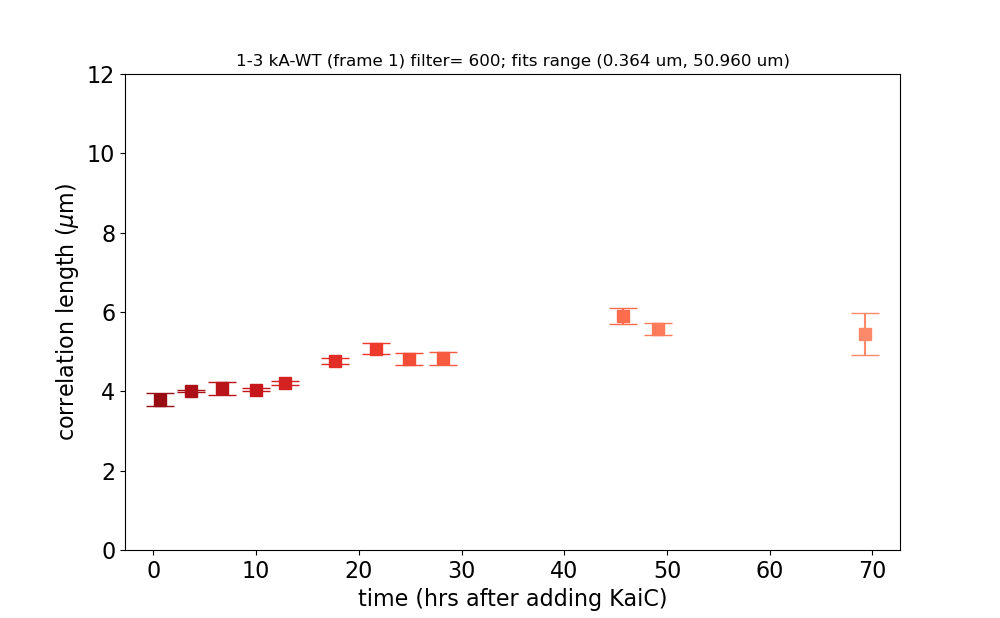

In [30]:
### set up empty arrays
all_cl = np.zeros((3,len(row1_cl)))
avg_cl = np.empty(len(row1_cl))
stderror_cl = np.empty(len(row1_cl))

### find average values and std. error for L1 correlation lengths based on the fits 
for i in range(len(row1_cl)):
    all_cl[0,i] = row1_cl[i]
    all_cl[1,i] = row2_cl[i]
    all_cl[2,i] = row3_cl[i]
    #print(all_L1.mean(axis=0))
avg_cl = all_cl.mean(axis=0)
stderror_cl = all_cl.std(axis=0)/np.sqrt(3)
print(stderror_cl)
print(all_cl)

### plot average values and std. error for L1 correlation lengths
fig, ax = plt.subplots(figsize=(fig_size))
markerSize = 8

for i in range(int(len(time_array))):
    plt.plot(time_array[i], avg_cl[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)))
    ax.errorbar(time_array[i], avg_cl[i], yerr = stderror_cl[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("correlation length ($\mu$m)",fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
plt.ylim(0,12)
title_plus = title + "; fits range (%5.3f um, %5.3f um)" %(all_xvalues[fit_start], x_fit_lim)
plt.title(title_plus, fontsize=font_size -4)
plt.show()

### save plot
fig.savefig(plot_saveto+"1-over-e correlation lengths for "+title_plus+".jpg", dpi=dpi_num)

In [15]:
### set p_range to the range of long range autocorrelation plateau values, use for saving data in CSV files
p_range = '(%5.1f, %5.1f)' %(all_xvalues[plat_range_from], all_xvalues[plat_range_to])
print(p_range)

( 30.9, 100.1)


## Save all results to 3 seperate CSV files --> use for plotting in origin later on 

In [16]:
### first CSV file: save fit parameters (coefficient 'A' and correlation length 'L1'), and avg autocorrelation plateau values
csv_data_file = exp+" --threshold results (for box plots"+", "+ "filter= " + fsize+")"+".csv"
data_file_exists = os.path.isfile(saveto_dir+csv_data_file)
if data_file_exists:
    print("Data file already exists.")
    with open(saveto_dir + csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([frame_names[key], '', 'filter= ' + fsize])
        writer.writerow(['',
                         'clusters detected','','','',
                         'max cluster size','','','',
                         'mean cluster size','','','',
                         'avg clustering of a pixel',''])
        writer.writerow(['time (hrs)',
                         'row1, 2, 3','','avg','std error',])
        for i in range(len(time_array)):
            writer.writerow([time_array[i], row1_cl[i], '','','' ])
            writer.writerow([time_array[i], row2_cl[i], '','','' ])
            writer.writerow([time_array[i], row3_cl[i], '', , avg_cl[i], stderror_cl[i] ])
            writer.writerow([time_array[i], 
                             row2_results[i][0], '','','',
                             row2_results[i][1], '','','',
                             row2_results[i][2], '','','',
                             row2_results[i][3], ''])
            writer.writerow([time_array[i], 
                             row3_results[i][0], avg_cnums[i], stderror_cnums[i], '',
                             row3_results[i][1], avg_max_size[i], stderror_max_size[i], '',
                             row3_results[i][2], avg_mean_size[i], stderror_mean_size[i], '', 
                             row3_results[i][3], '',])
        writer.writerow([''])
    f.close()
    print("Results appended to file.")
else:
    print("Data file does NOT exist.")
    header = []
    np.savetxt(saveto_dir+csv_data_file, header, fmt="%s", delimiter=',')
    with open(saveto_dir + csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([condition, '', stop_filter_index])
        writer.writerow(['',
                         'clusters detected','','','',
                         'max cluster size','','','',
                         'mean cluster size','','','',
                         'avg clustering of a pixel',''])
        writer.writerow(['time (hrs)',
                         'row1, 2, 3','avg','std error','',
                         'row1, 2, 3','avg','std error','',
                         'row1, 2, 3','avg','std error','',
                         'row1, 2, 3',''])
        for i in range(len(time_array)):
            writer.writerow([time_array[i], 
                             row1_results[i][0], '','','',
                             row1_results[i][1], '','','',
                             row1_results[i][2], '','','',
                             row1_results[i][3], '',])
            writer.writerow([time_array[i], 
                             row2_results[i][0], '','','',
                             row2_results[i][1], '','','',
                             row2_results[i][2], '','','',
                             row2_results[i][3], '',])
            writer.writerow([time_array[i], 
                             row3_results[i][0], avg_cnums[i], stderror_cnums[i], '',
                             row3_results[i][1], avg_max_size[i], stderror_max_size[i], '',
                             row3_results[i][2], avg_mean_size[i], stderror_mean_size[i], '', 
                             row3_results[i][3], '',])
        writer.writerow([''])
    f.close()
    print("New csv created, results appended to file.")

## First round complete! 
## Now we can scroll back to the top and change the 'key' variable to run through the next frame (i.e. condition) of all tiff files